### Preliminaries

In [2]:
using Plots, Statistics, Distributions, Optim, Random
Random.seed!(2359112412)

TaskLocalRNG()

# Exercise 6.3
## (a) Inverse Transform Sampling
First we derive the inverse CDF of the Pareto distribution to implement the sampling procedure.

With the PDF given we can get the CDF by integration and using the condition that $F_X(1) = 0$ (note 1 is the lower bound of the support).

$$ F_X(x) = C +  -x^{-\alpha} $$
so looking at $F_X(1)$ gives C = 1.

The quantile function is then given by
$$ F^{-1}_X(p) = (1-p)^{(-1/\alpha)}$$
for $p\in[0,1]$.

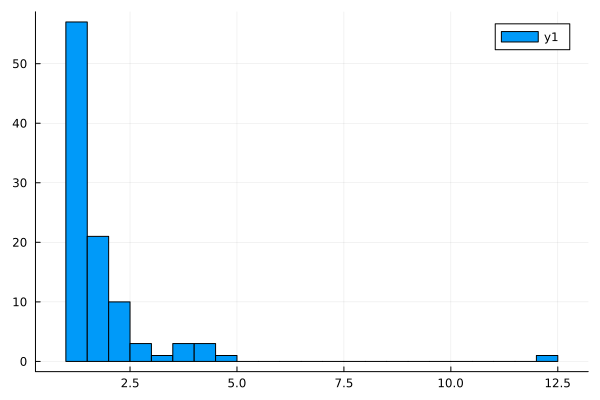

In [5]:
# Sampling Function
inv_cdf(p, α) = (1-p)^(-(1/α))

function sample_pareto(α, n)
    x = rand(Uniform(0,1), n)
    return inv_cdf.(x, α)
end

sample2 = sample_pareto2(2, 100)
histogram(sample2)

## (b) Maximum Likelihood Estimation
We first derive the log-likelihood function:
$$ L_n(\alpha) = \prod_{i = 1}^N \frac{\alpha}{X_i^{\alpha+1}}$$
which follows from the sample being iid. Taking logs and collecting terms we get the log-likelihood function
$$ l_n(\alpha) = n\ln(\alpha) - \sum_{i=1}^N (\alpha + 1)\ln(X_i).$$

To find the maximum-likelihood estimator $\hat{\alpha}_{mle}$, we maximize the above function with respect to $\alpha$.

Setting the first order condition to zero and rearranging terms we get the following estimator:
$$\hat{\alpha}_{mle} = \frac{n}{\sum_{i=1}^N\ln(X_i)}.$$

Next we solve the problem numerically by coding the (negative) log-likelihood and using an optimization routine to find the minimum.

In [6]:
# Define relevant functions (neg-log-likelihood, mle, simulation)
mle_analytic(x) = length(x) / sum(log.(x))

negll(α, x) = -(length(x) * log(α) - sum((α+1).*log.(x)))

function mle(x; lb=1, ub=10)
    f(α) = negll(α, x)
    return optimize(f, lb, ub).minimizer    
end

function simulate_mle(reps, n; α=2)
    out = zeros(reps, 2)

    for i in 1:reps
        sample = sample_pareto(α, n)
        out[i, 1] = mle(sample)
        out[i, 2] = mle_analytic(sample)
    end

    return out
end

simulate_mle (generic function with 1 method)

The below histogram plots the simulated distribution of $\hat{\alpha}_{mle}$ for 10,000 simulation runs and a sample size of $N=100$ and $N=1000$. We can see that for the larger sample the asymptotic distribution of the MLE (from class) seems to be a better approximation as expected.

In [14]:
results_50 = simulate_mle(10000, 50);
results_100 = simulate_mle(10000, 100);
results_1000 = simulate_mle(10000, 1000);

In [15]:
# Asymptotic variance of the MLE
A(n, α) = n/(α^2)
# B =
avar(n, α) = 1/A(n, α)
# avar2 = B/A^2 # not sure regularity conditions hold (e.g no variance)

avar (generic function with 1 method)

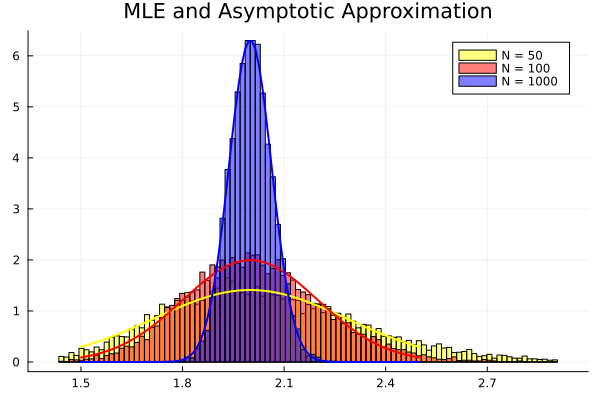

In [17]:
bins = range(minimum(results_100[:,1]), stop = maximum(results_100[:,1]), length = 100)

histogram(results_50[:,1], color=:yellow, normalize=:pdf, fillalpha = 0.5, bins = bins, label = "N = 50")
histogram!(results_100[:,1], color=:red, normalize=:pdf, fillalpha = 0.5, bins = bins, label = "N = 100")
histogram!(results_1000[:,1], color=:blue, normalize=:pdf, fillalpha = 0.5, bins = bins, label = "N = 1000")

grid = range(1.5, 2.5, 100)
plot!(grid, pdf.(Normal(2, sqrt(avar(50, 2))), grid), color =:yellow, lw = 2, label =:none)
plot!(grid, pdf.(Normal(2, sqrt(avar(100, 2))), grid), color =:red, lw = 2, label =:none)
plot!(grid, pdf.(Normal(2, sqrt(avar(1000, 2))), grid), color =:blue, lw = 2, label =:none)
plot!(title = "MLE and Asymptotic Approximation")

## (c) Comparison Solutions
To compare the solutions we can plot their difference from the simulation results above. Essentially, they do not differ. Probably numeric approximations are very accurate for those easier cases (which probably coincide with closed-form solutions being available).

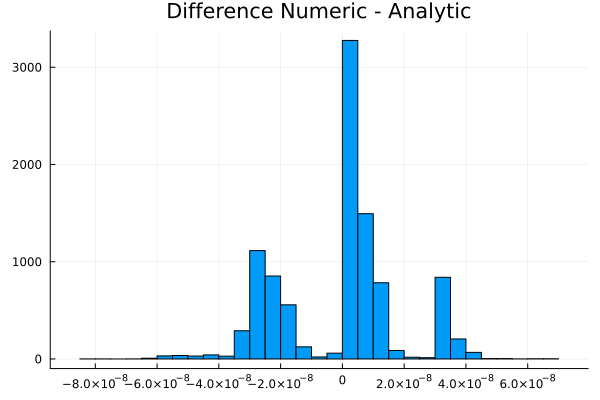

In [81]:
diff = results[:, 1] .- results[:, 2];
histogram(diff, label =:none, title = "Difference Numeric - Analytic")